In [1]:
from tensorflow import keras

from tensorflow.keras import models, layers

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error

import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np 

In [2]:
# Preparing the dataset and creating the features and target arrays


pd.set_option('mode.chained_assignment', None)

n_sims = 10000
n_list = [i for i in range(n_sims)]


h0s = []
results = []


start = 0
end = 10000

x = []
y =[]

for i in n_list[start:end]:
	
	data = np.load(f'input/data_{i+1}.npy')
	x.append(data[:, :2])
	y.append(data[:, 2:][0][0])
	print(f'Status: {((i+1)/end * 100):.2f} %', end='\r')


x = np.array(x)
# x[:,:,0] /= x[:,:,0].max()

y = np.array(y)


norm = y.max()


y /= norm

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.25)

In [3]:
early_stopping = keras.callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=5, # how many epochs to wait before stopping
    restore_best_weights=True,
)

In [4]:
# defining the model

model = models.Sequential()


model.add(layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(80, 2)))
model.add(layers.MaxPooling1D(pool_size=2))

model.add(layers.Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(80, 2)))
model.add(layers.MaxPooling1D(pool_size=2))

# model.add(layers.GRU(16, input_shape=(80,2)))

model.add(layers.Flatten())


model.add(layers.Dense(16))
model.add(layers.Dense(16))

model.add(layers.Dense(1))
model.compile(loss=keras.losses.MeanSquaredError(), optimizer='nadam')




history = model.fit(x_train, y_train, validation_split=.1, epochs=10, batch_size=32, verbose=1, callbacks=[early_stopping])

Epoch 1/10
211/211 [==============================] - 6s 9ms/step - loss: 4.5958 - val_loss: 7.1999e-05
Epoch 2/10
211/211 [==============================] - 1s 7ms/step - loss: 0.2261 - val_loss: 6.4373e-05
Epoch 3/10
211/211 [==============================] - 2s 8ms/step - loss: 0.0994 - val_loss: 1.3978e-04
Epoch 4/10
211/211 [==============================] - 1s 7ms/step - loss: 0.0753 - val_loss: 3.7154e-05
Epoch 5/10
211/211 [==============================] - 2s 9ms/step - loss: 0.0521 - val_loss: 0.0078
Epoch 6/10
211/211 [==============================] - 2s 9ms/step - loss: 1.6979e-04 - val_loss: 2.0477e-04


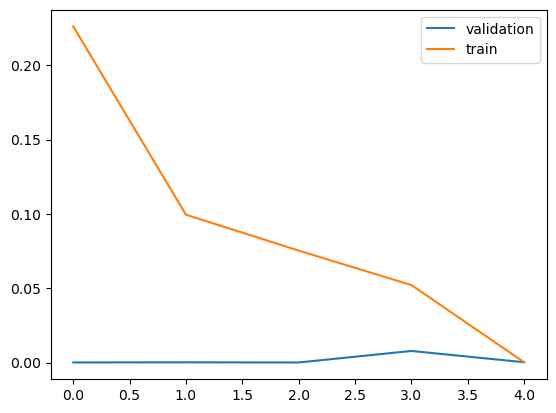

In [5]:
plt.plot(history.history['val_loss'][1:], label='validation')
plt.plot(history.history['loss'][1:], label='train')

plt.legend()
plt.show()

Dummy variables just for visualization purposes

In [6]:
y_pred = model.predict(x_test)


r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)



79/79 [==============================] - 0s 5ms/step


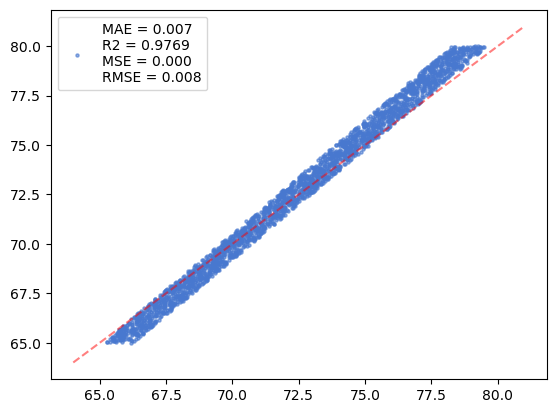

In [7]:
plt.style.use('seaborn-v0_8-muted')

linha = np.linspace(64, 81)
# linha = np.linspace(.31, .315, 2500)


plt.scatter(y_pred*norm, y_test*norm, s=5, alpha=.6, label=f'MAE = {mae:.3f}\nR2 = {r2:.4f}\nMSE = {mse:.3f}\nRMSE = {rmse:.3f}')
plt.plot(linha, linha, alpha=.5, c='red', ls='--')

plt.legend()
plt.savefig("imagens/metrics_h0_cnn")
plt.show()

In [8]:
# forecasting "real" H(0)

real = np.load('input/data_real80.npy')
real = real[real[:, 0].argsort()]

real = real.reshape(-1,80,2)

In [9]:

final_real = model.predict(real, verbose=0)

In [12]:
final_real*norm

array([[67.82561]], dtype=float32)

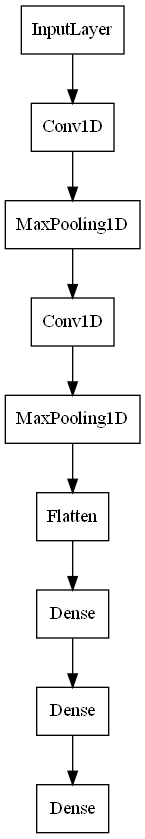

In [11]:
keras.utils.plot_model(model, to_file='imagens/model_cnn.png', show_shapes=False, show_layer_names=False)
